In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, DenseNet169, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Veri seti yolu
data_path = 'C:/Users/Andac/Desktop/VERİSETLERİVE KODLAR/Images'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
 
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
   
)

# Sanal bir test veri seti oluştur
fake_test_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Early stopping için callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# BayesianOptimization için model fonksiyonları
def build_densenet169(hp):
    densenet169_model = DenseNet169(include_top=False, input_shape=(224, 224, 3))
    for layer in densenet169_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(densenet169_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('densenet169_units', min_value=70, max_value=100, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('densenet169_dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('densenet169_learning_rate', min_value=7e-8, max_value=1.5e-7, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_inceptionv3(hp):
    inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
    for layer in inception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('inception_units', min_value=60, max_value=120, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('inception_dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('inception_learning_rate', min_value=7e-8, max_value=1.5e-7, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_vgg16(hp):
    vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    for layer in vgg16_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(vgg16_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('vgg16_units', min_value=70, max_value=120, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('vgg16_dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('vgg16_learning_rate', min_value=1e-7, max_value=6e-7, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# BayesianOptimization için tuner'ları oluştur
densenet169_tuner = BayesianOptimization(build_densenet169, objective='val_accuracy', max_trials=5, num_initial_points=2, project_name='densenet169_tuner')
inceptionv3_tuner = BayesianOptimization(build_inceptionv3, objective='val_accuracy', max_trials=5, num_initial_points=2, project_name='inceptionv3_tuner')
vgg16_tuner = BayesianOptimization(build_vgg16, objective='val_accuracy', max_trials=5, num_initial_points=2, project_name='vgg16_tuner')

# BayesianOptimization ile hiperparametre ayarı yap
densenet169_tuner.search(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping])
inceptionv3_tuner.search(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping])
vgg16_tuner.search(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping])



C:\Users\Andac\AppData\Local\Temp\ipykernel_1388\3490767070.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


Found 19200 images belonging to 24 classes.
Found 4800 images belonging to 24 classes.
Found 4800 images belonging to 24 classes.
Reloading Tuner from .\densenet169_tuner\tuner0.json
Reloading Tuner from .\inceptionv3_tuner\tuner0.json
Reloading Tuner from .\vgg16_tuner\tuner0.json


In [2]:
def build_inceptionv3(best_inceptionv3_params):
    inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
    for layer in inception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.Flatten())
    # best_inceptionv3_params sözlüğünden doğrudan değerleri kullan
    model.add(layers.Dense(units=best_inceptionv3_params['inception_units'], activation='relu'))
    model.add(layers.Dropout(best_inceptionv3_params['inception_dropout']))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=best_inceptionv3_params['inception_learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_densenet169(best_densenet169_params):
    densenet169_model = DenseNet169(include_top=False, input_shape=(224, 224, 3))
    for layer in densenet169_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(densenet169_model)
    model.add(layers.Flatten())
    # params sözlüğünden doğrudan değerleri kullan
    model.add(layers.Dense(units=best_densenet169_params['densenet169_units'], activation='relu'))
    model.add(layers.Dropout(best_densenet169_params['densenet169_dropout']))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=best_densenet169_params['densenet169_learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
    
def build_vgg16(best_vgg16_params):
    vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    for layer in vgg16_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(vgg16_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=best_vgg16_params['vgg16_units'], activation='relu'))
    model.add(layers.Dropout(best_vgg16_params['vgg16_dropout']))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=best_vgg16_params['vgg16_learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# En iyi hiperparametreleri al
best_inceptionv3_params = inceptionv3_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
best_densenet169_params = densenet169_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
best_vgg16_params = vgg16_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# En iyi hiperparametrelerle modelleri eğit
best_densenet169_model = build_densenet169(best_densenet169_params)
best_inceptionv3_model = build_inceptionv3(best_inceptionv3_params)
best_vgg16_model = build_vgg16(best_vgg16_params)


densenet169_history = best_densenet169_model.fit(train_generator, validation_data=val_generator, epochs=30)
inceptionv3_history = best_inceptionv3_model.fit(train_generator, validation_data=val_generator, epochs=30)
vgg16_history = best_vgg16_model.fit(train_generator, validation_data=val_generator, epochs=30)

Epoch 1/30
600/600 [==============================] - 187s 291ms/step - loss: 3.3277 - accuracy: 0.0903 - val_loss: 2.9634 - val_accuracy: 0.1365
Epoch 2/30
600/600 [==============================] - 172s 287ms/step - loss: 2.7746 - accuracy: 0.1993 - val_loss: 2.5601 - val_accuracy: 0.3406
Epoch 3/30
600/600 [==============================] - 172s 286ms/step - loss: 2.3740 - accuracy: 0.3609 - val_loss: 2.2030 - val_accuracy: 0.4825
Epoch 4/30
600/600 [==============================] - 172s 286ms/step - loss: 2.0280 - accuracy: 0.5038 - val_loss: 1.8831 - val_accuracy: 0.6075
Epoch 5/30
600/600 [==============================] - 172s 287ms/step - loss: 1.7195 - accuracy: 0.6112 - val_loss: 1.6087 - val_accuracy: 0.7146
Epoch 6/30
600/600 [==============================] - 172s 287ms/step - loss: 1.4641 - accuracy: 0.7023 - val_loss: 1.3844 - val_accuracy: 0.7923
Epoch 7/30
600/600 [==============================] - 172s 287ms/step - loss: 1.2552 - accuracy: 0.7617 - val_loss: 1.2034 -

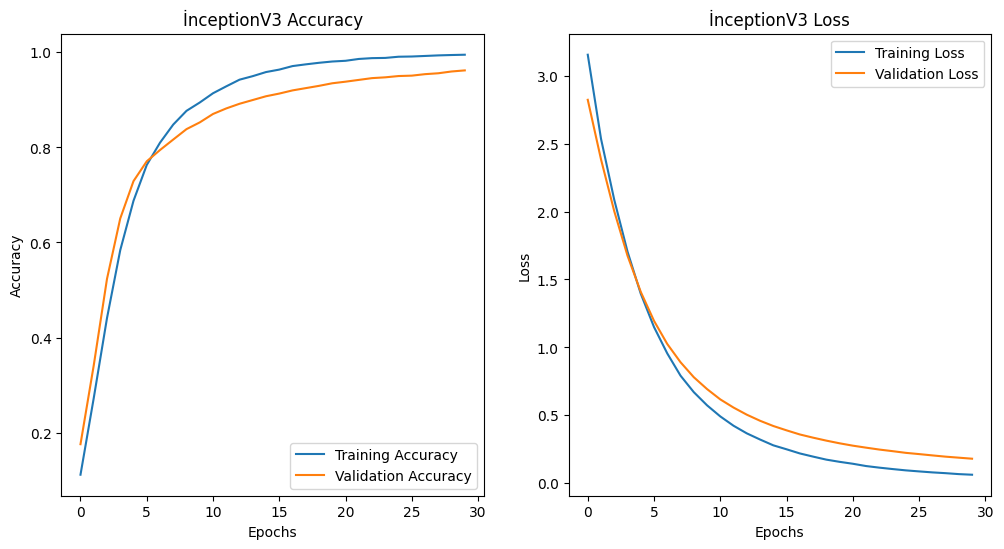

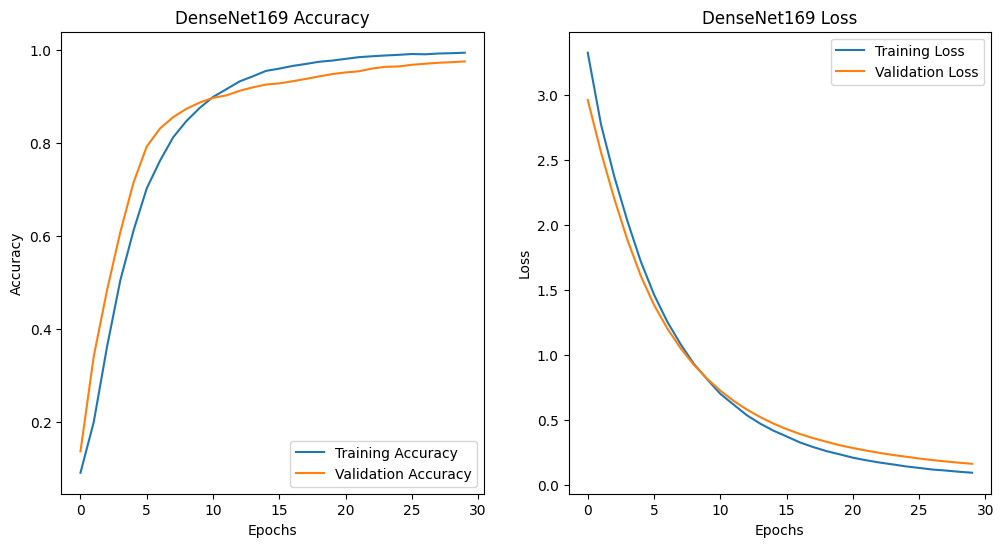

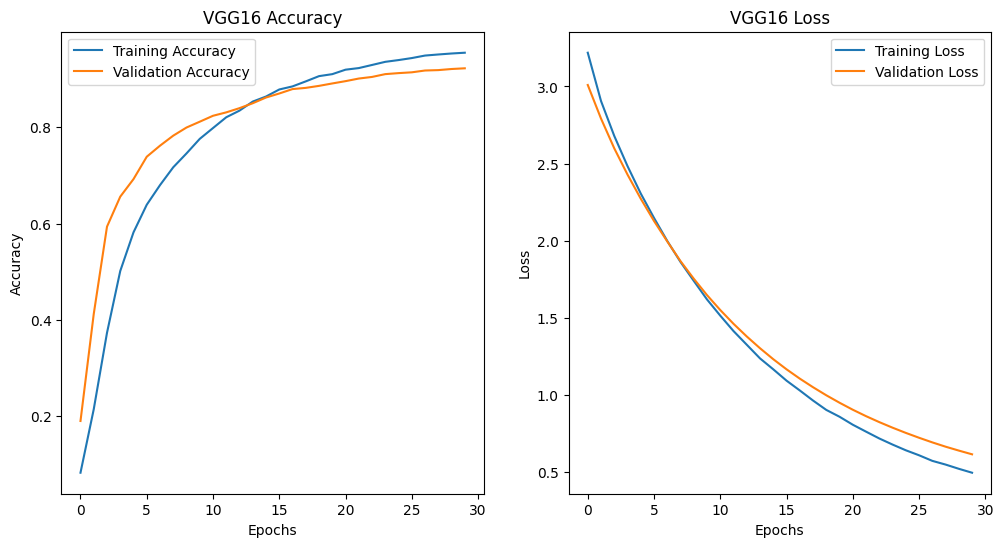

In [3]:
# Grafik çizimi
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Modellerin Eğitim Sonuçlarını Çiz
plot_history(inceptionv3_history, title='İnceptionV3')
plot_history(densenet169_history, title='DenseNet169')
plot_history(vgg16_history, title='VGG16')


In [5]:
# Test seti etiketlerini yükle
fake_test_labels = fake_test_generator.classes

# Modelleri ensemble etme
models = [best_inceptionv3_model, best_densenet169_model, best_vgg16_model]  # VGG16 modelini ekledik
weights = [0.3, 0.5, 0.2]  # Ağırlıklar

# Ensemble tahminlerini ağırlıklı olarak oluşturma
predictions_list = []
for model in models:
    predictions = model.predict(fake_test_generator, verbose=1)
    predictions_list.append(predictions)

weighted_predictions = np.zeros_like(predictions_list[0])
for predictions, weight in zip(predictions_list, weights):
    weighted_predictions += predictions * weight

ensemble_labels = np.argmax(weighted_predictions, axis=1)

# Toplam tahmin sayısına göre bir matris oluştur
ensemble_predictions = np.zeros((fake_test_generator.samples, 24))  # 24 sınıf için

# Tahminleri ve ağırlıkları kullanarak toplam tahmini hesapla
for predictions, weight in zip(predictions_list, weights):
    ensemble_predictions += predictions * weight

# Final tahminler (en yüksek skoru olan sınıfın indeksini al)
final_predictions = np.argmax(ensemble_predictions, axis=1)

# Performans metriklerini hesapla
accuracy_weighted = accuracy_score(fake_test_labels, final_predictions)
recall_weighted = recall_score(fake_test_labels, final_predictions, average='macro')
precision_weighted = precision_score(fake_test_labels, final_predictions, average='macro')
# Ensemble için F1 skorunu formülle hesapla
f1_weighted_direct = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted + 1e-15)

print(f'Ensemble Accuracy: {accuracy_weighted}')
print(f'Ensemble Recall: {recall_weighted}')
print(f'Ensemble Precision: {precision_weighted}')
print(f'Ensemble F1 Score: {f1_weighted_direct}')

# Her bir modelin ayrı ayrı değerlendirmesi
def evaluate_model(model, model_name):
    predictions = model.predict(fake_test_generator)
    predictions_classes = np.argmax(predictions, axis=1)
    f1 = 2 * (precision_score(fake_test_labels, predictions_classes, average='macro') * recall_score(fake_test_labels, predictions_classes, average='macro')) / (precision_score(fake_test_labels, predictions_classes, average='macro') + recall_score(fake_test_labels, predictions_classes, average='macro') + 1e-15)
    evaluation = model.evaluate(fake_test_generator)
    print(f"\n{model_name} Model Değerlendirmesi:")
    print("Loss:", evaluation[0])
    print("Accuracy:", evaluation[1])
    print("Precision:", precision_score(fake_test_labels, predictions_classes, average='macro'))
    print("Recall:", recall_score(fake_test_labels, predictions_classes, average='macro'))
    print("F1 Score:", f1)
    print("Classification Report:")
    print(classification_report(fake_test_labels, predictions_classes))

evaluate_model(best_inceptionv3_model, "InceptionV3")
evaluate_model(best_densenet169_model, "DenseNet169")
evaluate_model(best_vgg16_model, "VGG16")


150/150 [==============================] - 37s 245ms/step
Ensemble Accuracy: 0.9858333333333333
Ensemble Recall: 0.9858333333333332
Ensemble Precision: 0.9866445200006781
Ensemble F1 Score: 0.9862387598656877
150/150 [==============================] - 20s 134ms/step - loss: 0.1799 - accuracy: 0.9619

InceptionV3 Model Değerlendirmesi:
Loss: 0.1798851191997528
Accuracy: 0.9618750214576721
Precision: 0.9631354547169321
Recall: 0.961875
F1 Score: 0.9625048146993838
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.94      0.94      0.94       200
           2       0.93      1.00      0.97       200
           3       0.98      0.94      0.96       200
           4       0.97      1.00      0.99       200
           5       0.91      0.93      0.92       200
           6       1.00      1.00      1.00       200
           7       1.00      1.00      1.00       200
           8       1.00

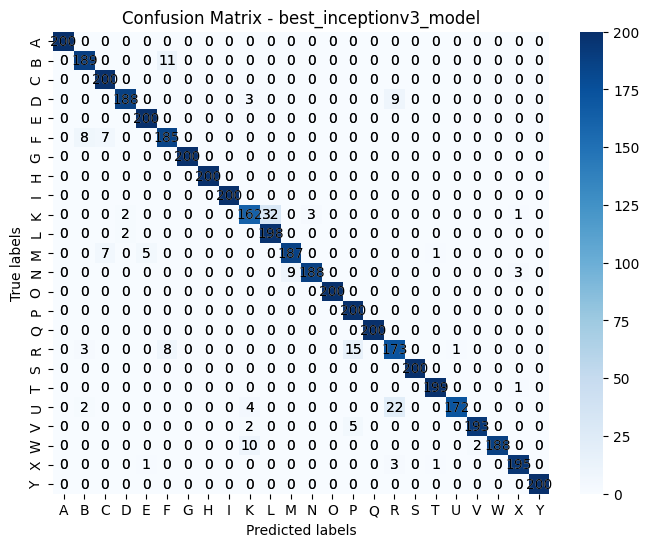

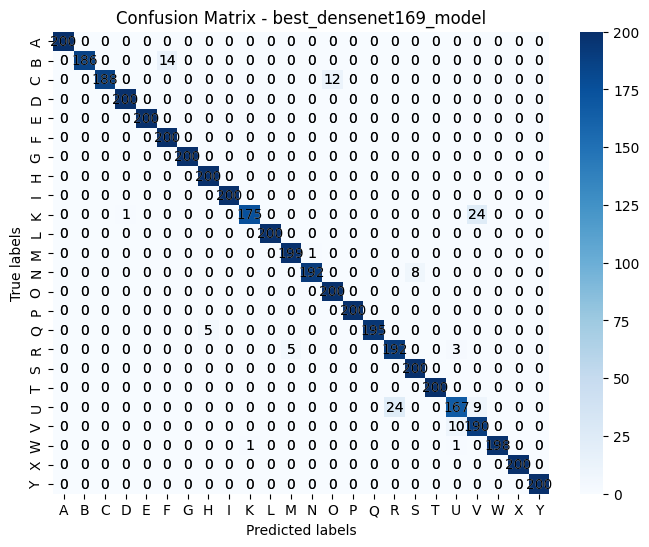

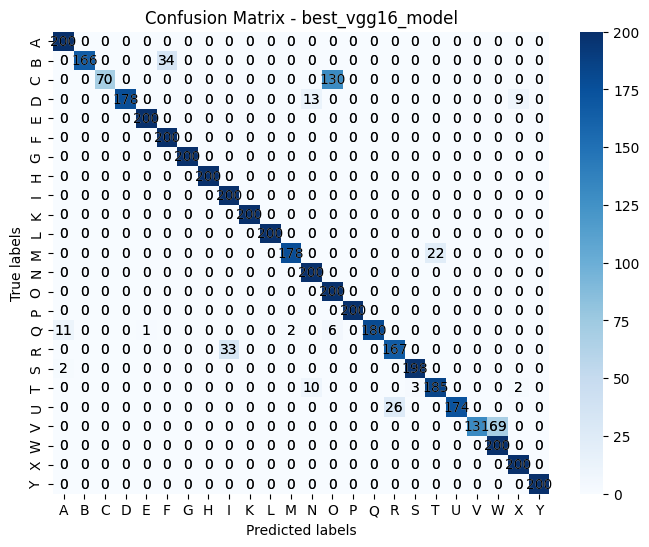

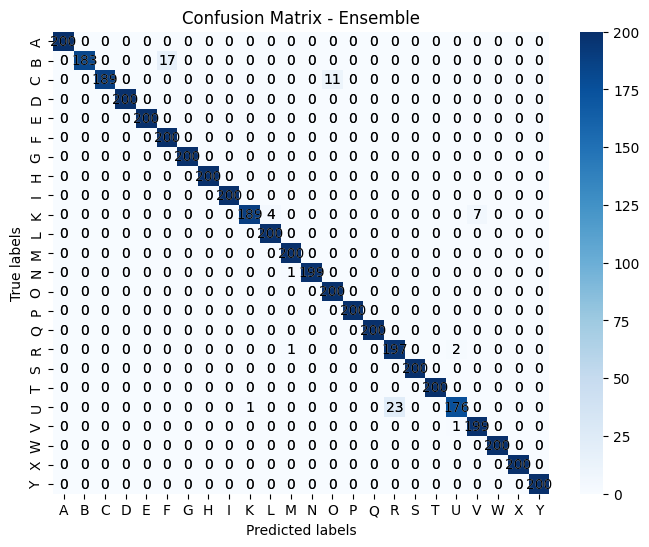

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model_names = ['best_inceptionv3_model', 'best_densenet169_model','best_vgg16_model']
for idx, predictions in enumerate(predictions_list):
    cm = confusion_matrix(val_generator.classes, np.argmax(predictions, axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.title(f'Confusion Matrix - {model_names[idx]}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    for i in range(len(val_generator.class_indices)):
        for j in range(len(val_generator.class_indices)):
            plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color='black')
    plt.show()

# Ensemble learning için confusion matrix oluştur
ensemble_cm = confusion_matrix(val_generator.classes, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - Ensemble')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
for i in range(len(val_generator.class_indices)):
    for j in range(len(val_generator.class_indices)):
        plt.text(j+0.5, i+0.5, ensemble_cm[i, j], ha='center', va='center', color='black')
plt.show()




1/1 [==============================] - 0s 24ms/step


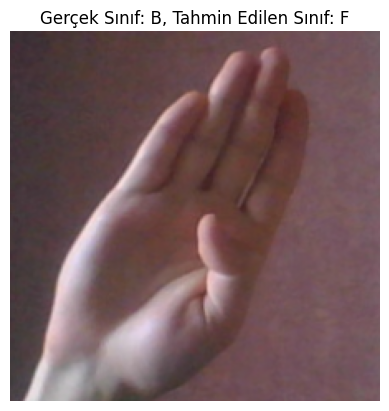

1/1 [==============================] - 0s 21ms/step


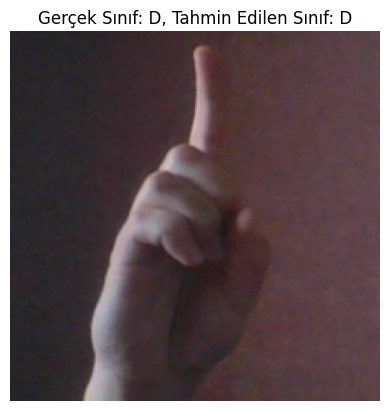

1/1 [==============================] - 0s 23ms/step


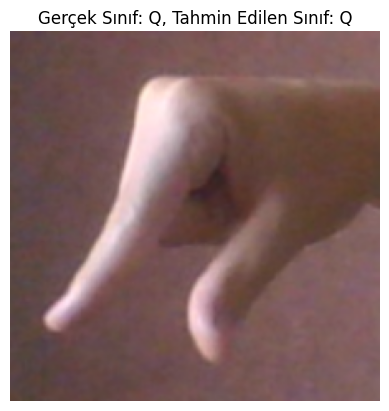

1/1 [==============================] - 0s 22ms/step


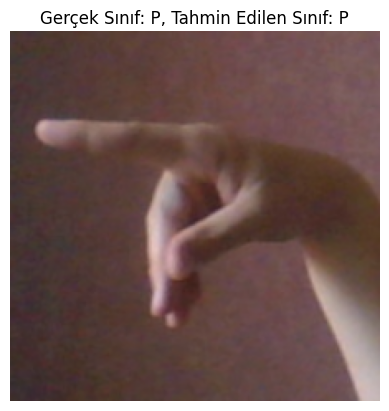

1/1 [==============================] - 0s 24ms/step


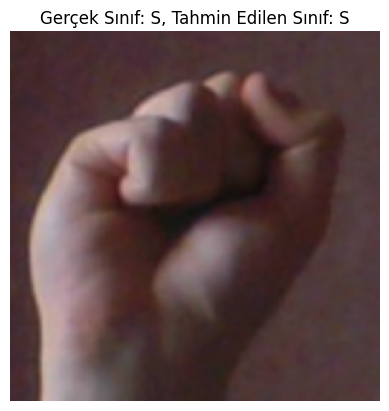

1/1 [==============================] - 0s 26ms/step


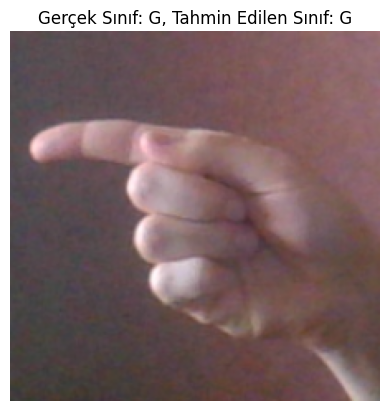

1/1 [==============================] - 0s 23ms/step


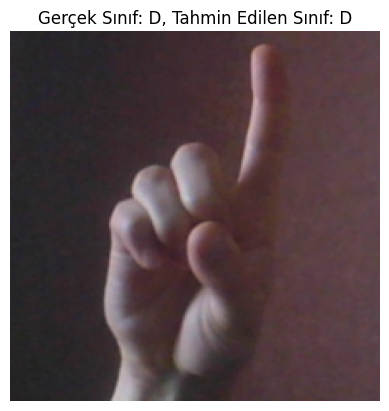

1/1 [==============================] - 0s 23ms/step


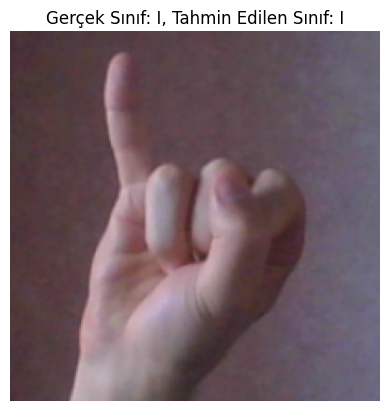

1/1 [==============================] - 0s 22ms/step


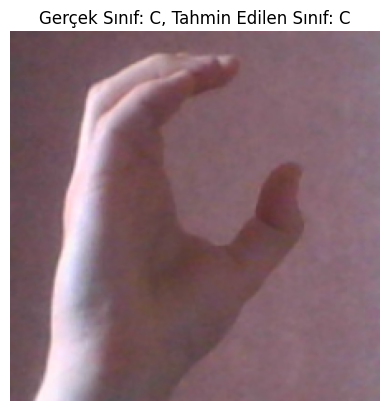

1/1 [==============================] - 0s 23ms/step


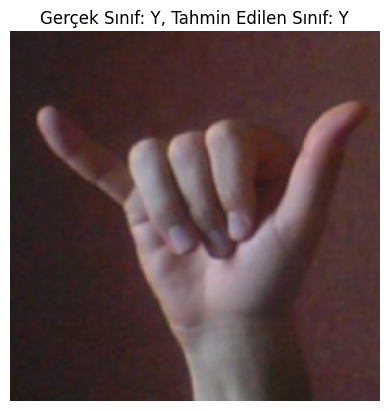

Toplam doğruluk: 0.9
1/1 [==============================] - 0s 23ms/step


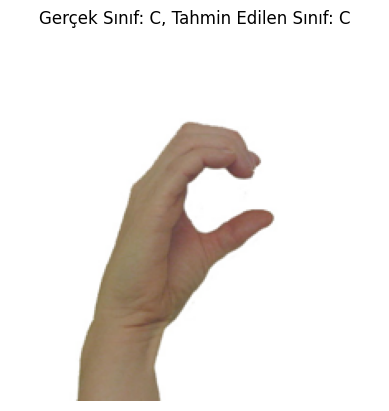

1/1 [==============================] - 0s 23ms/step


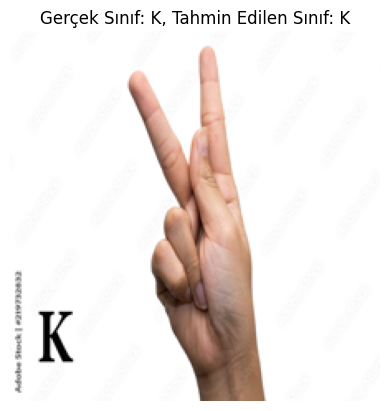

1/1 [==============================] - 0s 33ms/step


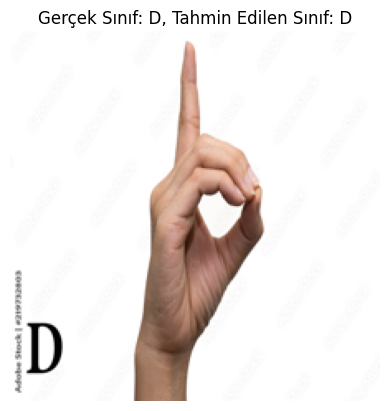

1/1 [==============================] - 0s 38ms/step


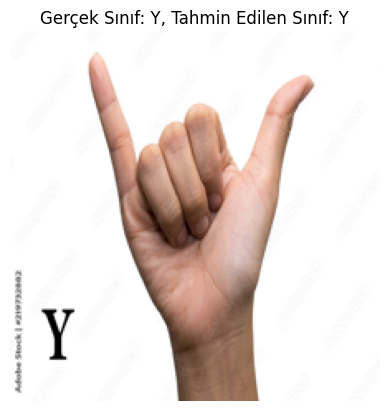

1/1 [==============================] - 0s 26ms/step


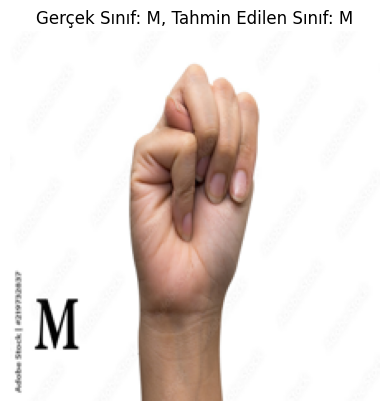

In [39]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os

# Sınıf isimlerini al
class_names = list(fake_test_generator.class_indices.keys())

# Rastgele 10 görüntü seçme
random_image_paths = random.sample(fake_test_generator.filepaths, 10)

# Gerçek etiketleri ve tahminleri tutacak listeler
true_labels = []
predicted_labels = []

# Seçilen rastgele görüntüler için tahminler yapma
for image_path in random_image_paths:
    # Görüntüyü yükleme
    image = Image.open(image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Gerçek etiketi alarak isme dönüştürme
    true_label_index = fake_test_generator.classes[fake_test_generator.filepaths.index(image_path)]
    true_label = class_names[true_label_index]  # Gerçek etiketi isme dönüştürme

    # Gerçek ve tahmin edilen etiketleri listelere ekleme
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()

# Doğruluk hesaplama
accuracy = accuracy_score(true_labels, predicted_labels)
print("Toplam doğruluk:", accuracy)

# Kullanıcı tarafından belirlenen iki özel görüntü
base_dir = 'C:/Users/Andac/Desktop/VERİSETLERİVE KODLAR'  # Dosya yolunu burada belirleyin

custom_image_paths = [
    os.path.join(base_dir, "C.jpg"),
    os.path.join(base_dir, "K.jpg"),
    os.path.join(base_dir, "D.jpg"),
    os.path.join(base_dir, "Y.jpg"),
    os.path.join(base_dir, "M.jpg")
]
custom_true_labels = ["C", "K", "D","Y","M"]  # Bu etiketleri gerçek sınıflarla güncelleyin

# Özel görüntüler için tahminler yapma
for custom_image_path, custom_true_label in zip(custom_image_paths, custom_true_labels):
    # Görüntü yolunun var olup olmadığını kontrol etme
    if not os.path.exists(custom_image_path):
        print(f"Dosya bulunamadı: {custom_image_path}")
        continue
    
    # Görüntüyü yükleme
    image = Image.open(custom_image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {custom_true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()